This notebook is an example of using the `residuated-binars` package for looking for finite models of lattices.

In [1]:
# First, let's prepare directories
!rm -rf hyp task
!mkdir hyp

We use the `generate_isabelle_theory_file` function to write an [Isabelle](https://isabelle.in.tum.de/) theory file containing lattice axioms.

This function writes a file containing a single lemma. So, we pass all but one lattice axiom as the `assumptions` argument and the negation of the last lattice axiom as the `goal`. A counter-example for such a 'lemma' will be exactly something obeying all the lattice axioms.

In [2]:
from residuated_binars.constants import LATTICE
from residuated_binars.generate_theories import generate_isabelle_theory_file

with open("hyp/Lattice.thy", "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE[:-1],
            goal="(" + LATTICE[-1] + ")"
        ))
    )
# notice the `oops` line. It means we provide no proof for our lemma
!cat hyp/Lattice.thy

theory Lattice
imports Main
begin
lemma "(
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = meet(y, x)) &
(\<forall> x::nat. \<forall> y::nat. join(x, y) = join(y, x)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. meet(x, meet(y, z)) = meet(meet(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. join(x, join(y, z)) = join(join(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. meet(x, join(x, y)) = x)
) \<longrightarrow>
((\<forall> x::nat. \<forall> y::nat. join(x, meet(x, y)) = x))
"
oops
end

We need to add a task for Isabelle server to do something with our lemma. The `add_task` function supports two types of tasks:

* [sledgehammer](https://isabelle.in.tum.de/dist/Isabelle2021-1/doc/sledgehammer.pdf) --- apply Automated Theorem Provers to find proof for a lemma (not our case)
* [nitpick](https://isabelle.in.tum.de/dist/Isabelle2021-1/doc/nitpick.pdf) --- apply Satisfiability Modulo Theory solvers to find a counter-example for a lemma (that's what we want to do)

The function `add_task` works with a folder of theory files and adds the same task for every theory file in a directory. It doesn't touch original files but creates a new directory with modified ones.

In [3]:
from residuated_binars.add_task import add_task, TaskType

# we search a minimal non-trivial example of a lattice, of size two
add_task(
    source_path="hyp",
    target_path="task",
    task_type=TaskType.NITPICK,
    cardinality=2
)
# notice that since there was only one theory file in the `hyp` folder,
# there is only one in the `task` folder.
# there is only one theory file in the `task` folder too
!ls task
!cat task/Lattice.thy

Lattice.thy
theory Lattice
imports Main
begin
lemma "(
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = meet(y, x)) &
(\<forall> x::nat. \<forall> y::nat. join(x, y) = join(y, x)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. meet(x, meet(y, z)) = meet(meet(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. join(x, join(y, z)) = join(join(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. meet(x, join(x, y)) = x)
) \<longrightarrow>
((\<forall> x::nat. \<forall> y::nat. join(x, meet(x, y)) = x))
"
nitpick[card nat=2,timeout=1000000,max_threads=0]
oops
end

We use [isabelle-client](https://pypi.org/project/isabelle-client/) to send our theory files to the Isabelle server. The function `check_assumptions` is a wrapper for it. The Isabelle server processes all the theory files from a folder in parallel.

In [4]:
from residuated_binars.check_assumptions import check_assumptions

# notice that after running this command
# there appears a new file `isabelle.out` in the `task` folder.
# It contains the log of communication to the Isabelle server
check_assumptions("task")
!ls task

isabelle.out  Lattice.thy


`residuated-binars` provide a parser of Isabelle server logs for extracting models found by Nitpick. For now, it can parse models of lattices and residuated binars.

In [5]:
from residuated_binars.parser import isabelle_response_to_algebra

lattices = isabelle_response_to_algebra("task/isabelle.out")

In [6]:
# we have only one model since we had only one theory file
# notice that all the results of join are zeros.
# That makes zero the greatest element
lattices

[{'join': [[0, 0], [0, 0]], 'meet': [[0, 1], [1, 1]]}]

In [7]:
# we can rename symbols to make zero the smallest element
lattices[0].canonise_symbols()
lattices

[{'join': [[1, 1], [1, 1]], 'meet': [[0, 0], [0, 1]]}]

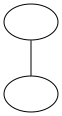

In [8]:
# we also can draw a Hasse diagram of the lattice
# to get more intuition about its structure
lattices[0].graphviz_repr

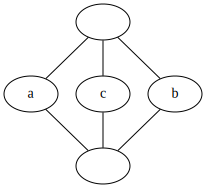

In [9]:
# here is an example of a lattice that is modular but not distributive
from residuated_binars.constants import RIGHT_DISTRIBUTIVITY, MODULARITY

!rm -rf hyp task; mkdir hyp
with open("hyp/Lattice.thy", "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE + [MODULARITY],
            goal=(
                RIGHT_DISTRIBUTIVITY
                .replace("f(", "meet(")
                .replace("g(", "join(")
            )
        ))
    )
add_task("hyp", "task", TaskType.NITPICK, 5)
check_assumptions("task")
lattices = isabelle_response_to_algebra("task/isabelle.out")
lattices[0].canonise_symbols()
lattices[0].graphviz_repr

In [ ]:
# and an example of a lattice that is not modular
!rm -rf hyp task; mkdir hyp
with open("hyp/Lattice.thy", "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE,
            goal=MODULARITY
        ))
    )
add_task("hyp", "task", TaskType.NITPICK, 5)
check_assumptions("task")
lattices = isabelle_response_to_algebra("task/isabelle.out")
lattices[0].canonise_symbols()
lattices[0].graphviz_repr

In [11]:
# here is an example of automatic proof that
# every distributive lattice is also modular
!rm -rf hyp task; mkdir hyp
with open("hyp/Lattice.thy", "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE + [
                RIGHT_DISTRIBUTIVITY
                .replace("f(", "meet(")
                .replace("g(", "join(")
            ],
            goal=MODULARITY
        ))
    )
add_task("hyp", "task", TaskType.SLEDGEHAMMER)
check_assumptions("task")

In [12]:
!grep "Proof found" ./task/isabelle.out

FINISHED {"ok":true,"errors":[],"nodes":[{"messages":[{"kind":"writeln","message":"Sledgehammering...","pos":{"line":15,"offset":569,"end_offset":581,"file":"/home/isabelle/task/Lattice.thy"}},{"kind":"writeln","message":"\"vampire\": Error: The Vampire prover is not activated; to activate it, set\n                  the Isabelle system option \"vampire_noncommercial\" to\n                  \"yes\" (e.g. via the Isabelle/jEdit menu Plugin Options /\n                  Isabelle / General)\n","pos":{"line":15,"offset":569,"end_offset":581,"file":"/home/isabelle/task/Lattice.thy"}},{"kind":"writeln","message":"Proof found...","pos":{"line":15,"offset":569,"end_offset":581,"file":"/home/isabelle/task/Lattice.thy"}},{"kind":"writeln","message":"\"cvc4\": Try this: by (smt (verit, del_insts)) (774 ms)","pos":{"line":15,"offset":569,"end_offset":581,"file":"/home/isabelle/task/Lattice.thy"}},{"kind":"writeln","message":"\"verit\": Try this: by (smt (verit)) (767 ms)","pos":{"line":15,"offset":5